In [19]:
!pip install camb
!pip install bayesflow

In [20]:
import tensorflow as tf


try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    
    # To go fast on a TPU, increase the batch size. The rule of thumb is to use batches 
    # of 128 elements per core (ex: batch size of 128*8=1024 for a TPU with 8 cores).
    batch_size = 16 * strategy.num_replicas_in_sync
    print('Number of replicas:', strategy.num_replicas_in_sync, 'batch_size:',batch_size)
    
    print('TPU')
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)
    print('CPU or GPU')

Number of replicas: 1
CPU or GPU


In [21]:
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import camb
from camb import model
import bayesflow as bf
from scipy.stats import truncnorm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [22]:
K_MIN, K_MAX, N_K = 1e-4, 1.0, 256
k_grid = np.logspace(np.log10(K_MIN), np.log10(K_MAX), N_K).astype(np.float32)

def simulate_pk(theta, z: float = 0.0, *, sigma_frac: float = 0.05, seed: int | None = None):
    """Generate power spectrum for one cosmology with numerical stability"""
    rng = np.random.default_rng(seed)

    # Ensure numerical stability
    h = theta['H0'] / 100.0
    ombh2 = 0.02237
    omch2 = max(theta['Omega_m'] * h**2 - ombh2, 1e-5)  # Prevent negative values

    # CAMB setup with error handling
    try:
        pars = camb.CAMBparams()
        pars.set_accuracy(AccuracyBoost=2, lSampleBoost=2)
        pars.set_cosmology(H0=theta['H0'], ombh2=ombh2, omch2=omch2,
                           mnu=0.06, tau=0.0543)
        pars.InitPower.set_params(As=2.1e-9, ns=theta['n_s'])
        pars.set_matter_power(redshifts=[z], kmax=K_MAX*1.2, k_per_logint=30)
        pars.NonLinear = model.NonLinear_both
        pars.Transfer.high_precision = True

        pk_res = camb.get_matter_power_interpolator(
            pars, zs=[z], kmax=K_MAX*1.2, nonlinear=True,
            hubble_units=False, k_hunit=True
        )
        pk_interp = pk_res[0] if isinstance(pk_res, tuple) else pk_res

        # Calculate power spectrum with NaN protection
        P_nl = pk_interp.P(z, k_grid)
        if np.any(np.isnan(P_nl)):
            raise RuntimeError("NaN values in power spectrum")

        # Multiplicative noise preserves positivity
        noise = 1 + rng.normal(0.0, sigma_frac, P_nl.shape)
        noisyP = P_nl * noise

        return {'k': k_grid, 'P': noisyP.astype(np.float32)}

    except Exception as e:
        print(f"Error in CAMB: {e}")
        # Return fallback data with correct shape
        return {'k': k_grid, 'P': np.ones_like(k_grid) * 1e-10}

In [23]:
# ---- 2. BayesFlow simulator & wrappers -----------------------------

def prior():
    rng = np.random.default_rng()

    H0 = rng.uniform(55, 75)
    
    a_Om, b_Om = (0.25 - 0.315)/0.025, (0.40 - 0.315)/0.025
    Omega_m = truncnorm(a_Om, b_Om, loc=0.315, scale=0.025).rvs(random_state=rng)
    
    n_s_raw = rng.gamma(shape=20.0, scale=0.05)  
    n_s = np.clip(n_s_raw, 0, 2)

    return dict(
        H0=np.float32(H0),
        Omega_m=np.float32(Omega_m),
        n_s=np.float32(n_s)
    )


def likelihood(H0, Omega_m, n_s, **kwargs):
    """Return a noisy matter power spectrum for the given cosmology."""
    theta = dict(H0=float(H0), Omega_m=float(Omega_m), n_s=float(n_s))
    return simulate_pk(theta)

# BayesFlow will chain the two callables automatically
simulator = bf.make_simulator([prior, likelihood])


#-------------------- Plot for debugging purposes -----------------------------
# prior_samples = simulator.simulators[0].sample(1000)
# grid = bf.diagnostics.plots.pairs_samples(
#     prior_samples, variable_keys=["H0", "Omega_m", "n_s"]
# )

In [56]:
# ----- Adapter, networks, approximator (unchanged) ------------------------ 
adapter = (
    bf.Adapter()
    .convert_dtype("float64", "float32")
    .concatenate(["H0", "Omega_m", "n_s"], into="inference_variables")
    .rename("P", "summary_variables")
    .log(["inference_variables", "summary_variables"], p1=True)
    .expand_dims("summary_variables", axis=-1)
)
       

    #-------- Print the adapter structure for debugging purposes --------
    # print(adapter)
    # adapted_sims = adapter(simulator.sample(2))
    # print(adapted_sims["summary_variables"].shape)
    # print(adapted_sims["inference_variables"].shape)

optimizer = tf.keras.optimizers.Adam(
    learning_rate = 5e-4,      # mutable float
    beta_1        = 0.9,
    beta_2        = 0.999,
    epsilon       = 1e-7,
)

summary_net = bf.networks.TimeSeriesNetwork(
    recurrent_type="lstm",
    summary_dim=128,   
    filters=64,
    groups=8,
    dropout_rate=0.08
)

inference_net = bf.networks.CouplingFlow(
    num_flows=14,          # Increase flows for flexibility
    hidden_units=256,     # More units for capacity
    depth=6,
    permutation="orthogonal",
)
    
approximator = bf.approximators.ContinuousApproximator(
    adapter           = adapter,
    summary_network   = summary_net,
    inference_network = inference_net,
)
    
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    optimizer=optimizer, 
    inference_network=inference_net,
    summary_network=summary_net,
    approximator=approximator,
    metrics=["loss"],
    standardise=None
)

In [57]:
# training_data = workflow.simulate(6000,num_workers=os.cpu_count()) # type: ignore
# validation_data = workflow.simulate(1200,num_workers=os.cpu_count()) # type: ignore

# np.savez_compressed("train.npz", **training_data)
# np.savez_compressed("val.npz", **validation_data)

# load the data
training_data = dict(np.load("/kaggle/input/samples/train.npz"))
validation_data = dict(np.load("/kaggle/input/samples/val.npz"))

In [58]:
history = workflow.fit_offline(
    data=training_data,
    epochs=150,
    batch_size=256,
    validation_data=validation_data,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True,
        ),
        ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,          # Reduce LR by half
            patience=6,          # Wait 6 epochs with no improvement
            min_lr=1e-6,         # Minimum LR
            verbose=1,
        ),
    ],
)

Epoch 1/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 162ms/step - loss: 3.6959 - val_loss: 2.5305 - learning_rate: 5.0000e-04
Epoch 2/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 2.5855 - val_loss: 1.7764 - learning_rate: 5.0000e-04
Epoch 3/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 1.6867 - val_loss: 3.1985 - learning_rate: 5.0000e-04
Epoch 4/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 2.2242 - val_loss: 1.4802 - learning_rate: 5.0000e-04
Epoch 5/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 1.2093 - val_loss: 0.2540 - learning_rate: 5.0000e-04
Epoch 6/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 1.2920 - val_loss: 1.3064 - learning_rate: 5.0000e-04
Epoch 7/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 1.2084 - val_loss: 0.6173 - learning_rate: 5.0000e-04
Epoch 8/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 1.0334 - val_loss: 0.5577 - learning_rate: 5.0000e-04
Epoch 9/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0520 - val_loss: -0.7645

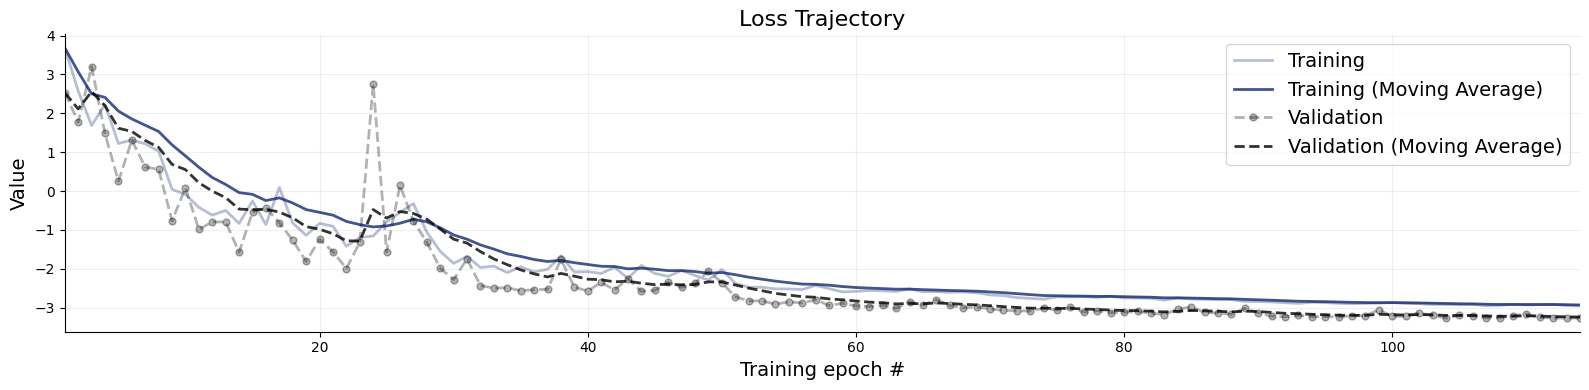

In [59]:
f = bf.diagnostics.plots.loss(history)

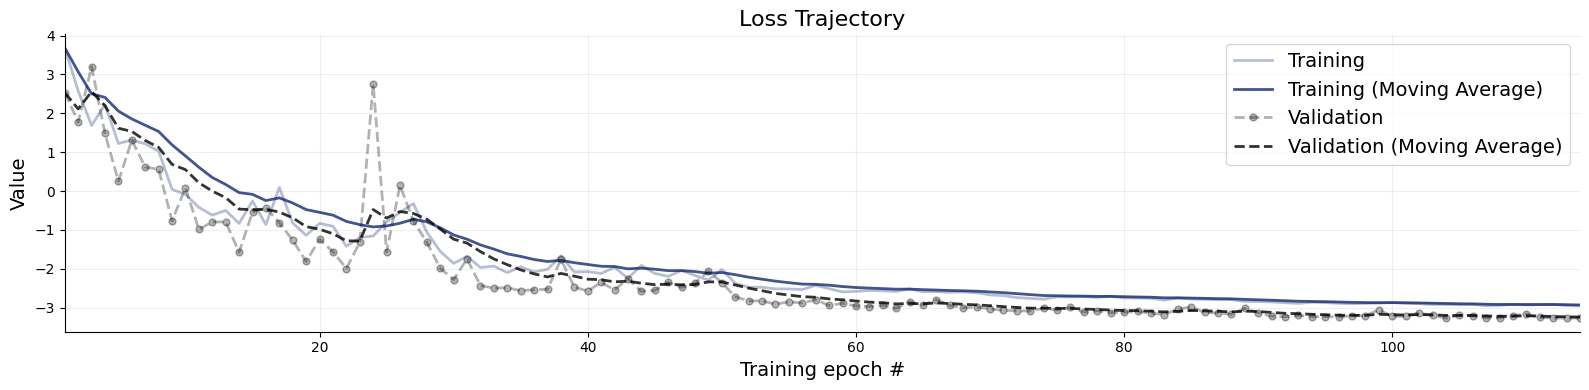

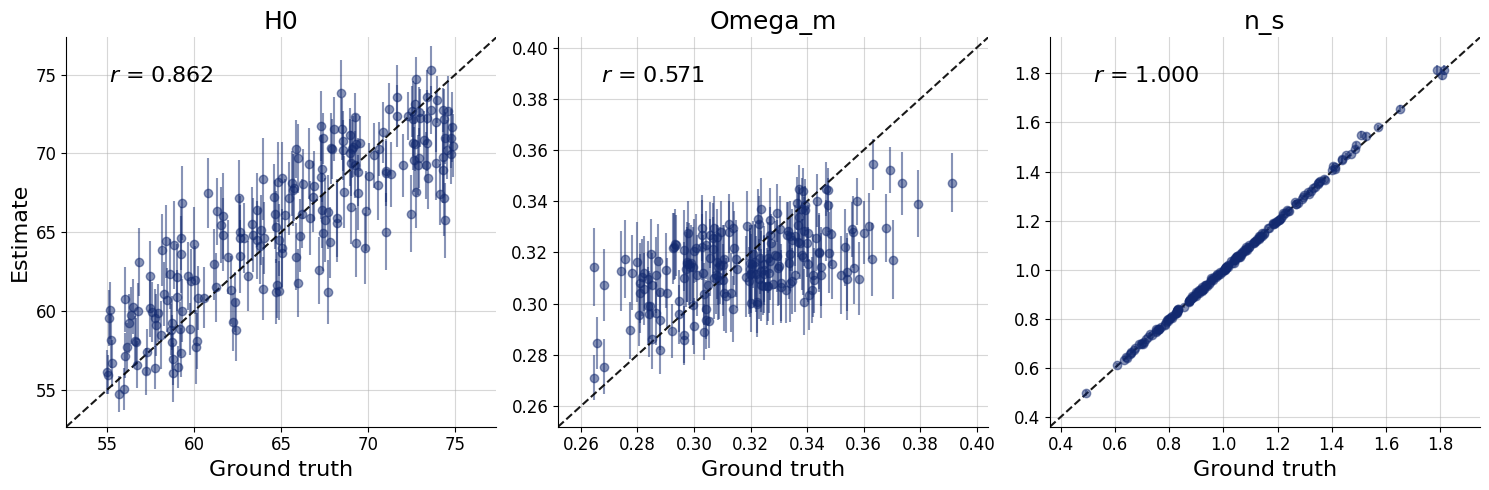

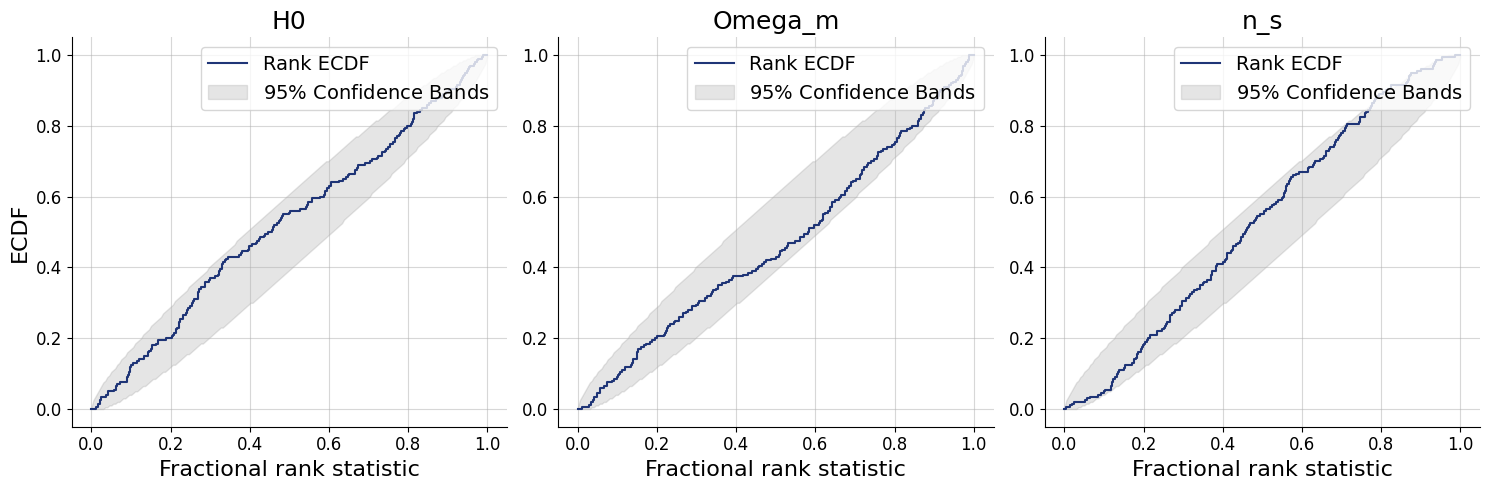

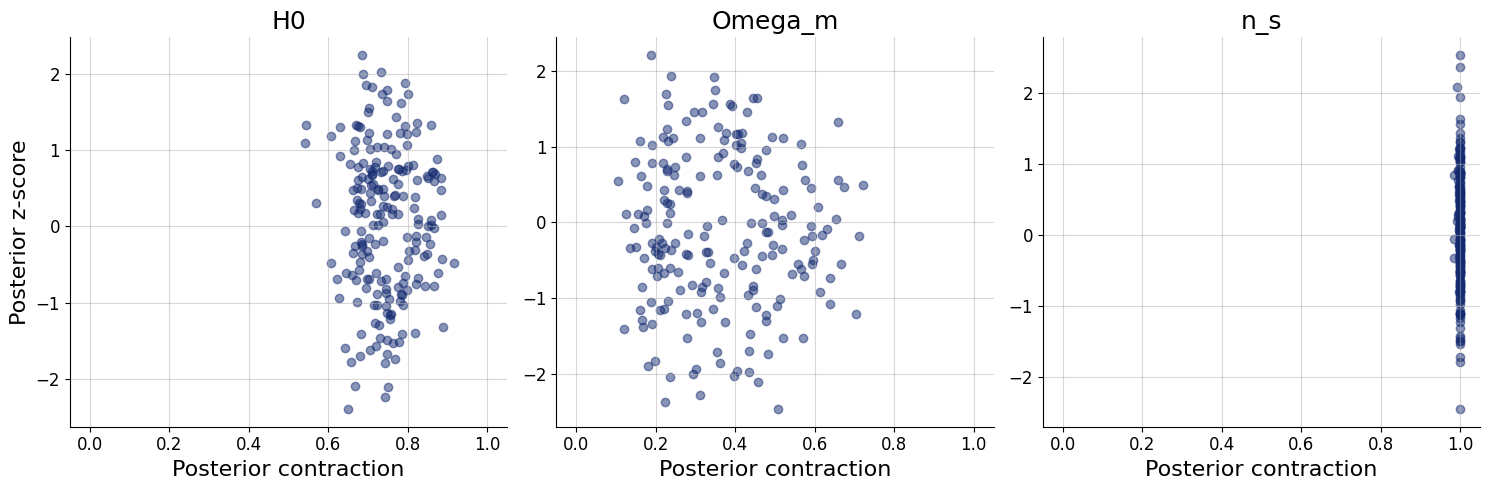

In [65]:
diagnostics=workflow.plot_default_diagnostics(test_data=200)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

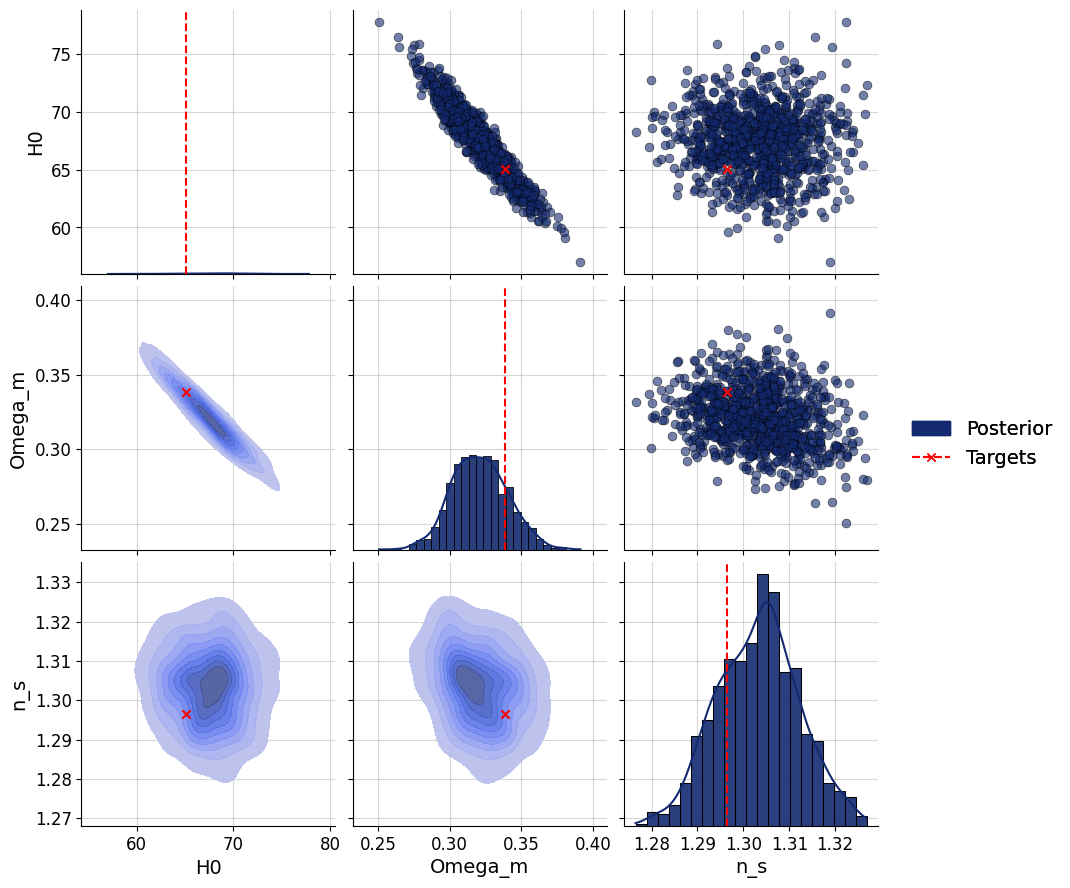

In [66]:
num_samples=1000
post_draws = workflow.sample(conditions=validation_data, num_samples=num_samples)
par_names = ["H0", "Omega_m", "n_s"]
post_draws.keys()
f = bf.diagnostics.plots.pairs_posterior(
    estimates=post_draws, 
    targets=validation_data,
    dataset_id=0,
    variable_names=par_names,
)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


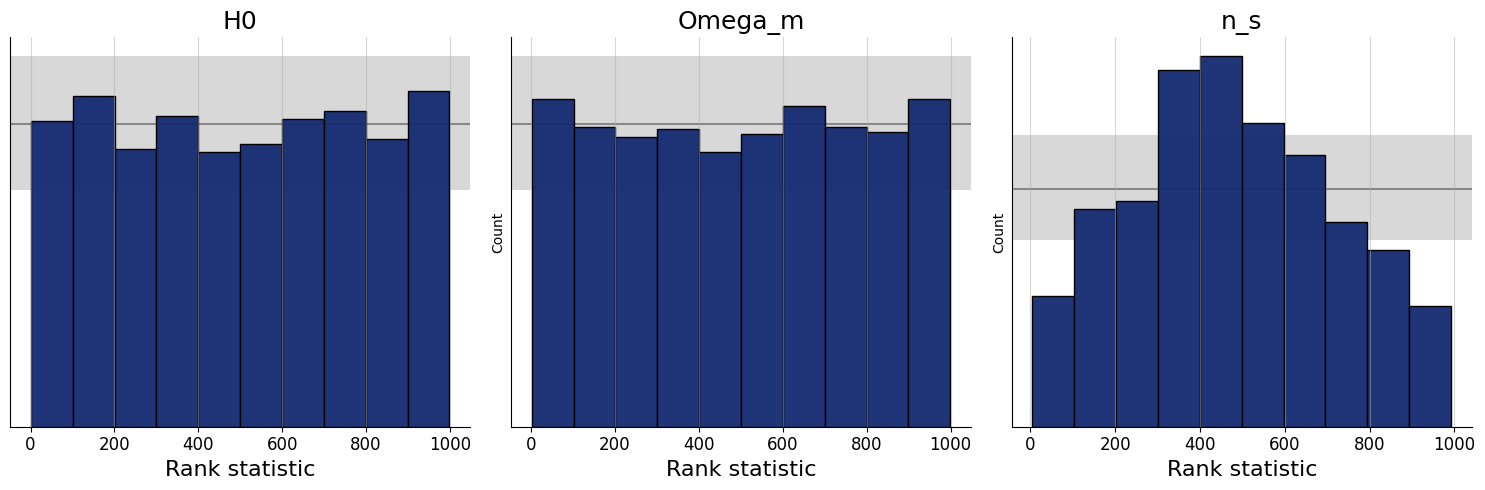

In [67]:
f = bf.diagnostics.plots.calibration_histogram(
    estimates= post_draws,
    targets=validation_data,
    variable_names=par_names
)